In [1]:
%run 'Functions.ipynb'

/home/katya/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [2]:
import networkx as nx
from scipy.stats import spearmanr, pearsonr

In [56]:
def train_nn(segment):
    
    min_max_scaler = MinMaxScaler()
    n_iter = 200

    chunk = 'S'+str(segment)
    
    print chunk

    data, labels, unique_mutations, aa_seq, mut_list= read_data_all_positions(chunk)

    scaledLabels = min_max_scaler.fit_transform(labels.reshape(-1,1))

    x_train, x_valid, y_train, y_valid = train_test_split(data, scaledLabels, test_size = 0.01)

    model = Sequential()

    model.add(Dense(5, input_dim=data.shape[1], activation='relu', kernel_initializer='glorot_normal'))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(60, activation='relu'))
    model.add(Dense(1, activation='relu'))

    opt = optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.0)

    model.compile(optimizer=opt,
                  loss='mean_squared_error',
                  verbose=0)

    hist = model.fit(x_train, y_train, validation_data=[x_valid, y_valid], 
                            epochs=n_iter, batch_size=500, shuffle=True, verbose=0)

    proba = model.predict_proba(data, batch_size=500, verbose=0)

    weights = model.layers[0].get_weights()[0]
    biases = model.layers[0].get_weights()[1]

    true = labels
    predicted = min_max_scaler.inverse_transform(proba)
    predicted = predicted.flatten()
    fitness_potential = data.dot(weights) + biases
    
    return true, predicted, weights, fitness_potential, mut_list, data, unique_mutations, aa_seq

In [57]:
def extract_epistatic_mutations(segment):
    df_segment=df[df.SegN==segment].reset_index(drop=True)
    
    position_list=[str(x) for x in (df_segment.VarPos-1)]
    aa_list=[x[1] for x in df_segment.Perm]
    mut1_list = [str(t[0]+t[1]) for t in zip(position_list, aa_list)]

    position_list=[str(x) for x in (df_segment.SubPos-1)]
    aa_list=[x[1] for x in df_segment.SubPerm]
    mut2_list = [str(t[0]+t[1]) for t in zip(position_list, aa_list)]
    
    return mut1_list, mut2_list, df_segment

In [58]:
df = pd.read_excel('../../dimensions/SignEpiPairs.xlsx')
df=df[df.pBon<0.05]

S1
(0.90145115100811068, 0.0)
1 SpearmanrResult(correlation=-0.19779990456193125, pvalue=0.34324344366984827)


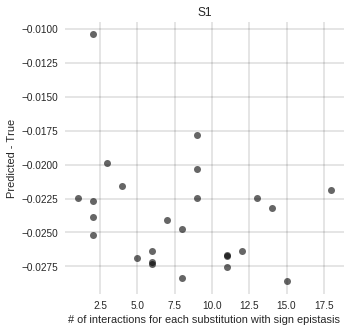

In [59]:
for segment in range(1,2):
    
    true, predicted, weights, fitness_potential, mut_list, data, unique_mutations, aa_seq = train_nn(segment)
    mut1_list, mut2_list, df_segment = extract_epistatic_mutations(segment)
    
    print pearsonr(true,predicted)
    
    H = nx.Graph()

    for i in range(len(mut1_list)):
        
        if mut1_list[i] not in H.nodes():
            H.add_node(mut1_list[i])
        if mut2_list[i] not in H.nodes():
            H.add_node(mut2_list[i])
            
        H.add_edge(mut1_list[i], mut2_list[i], {'color':'gray','thickness':2})

    differences_epistasis=[]
    differences_random=[]

    all_inds = np.array([x for x in range(len(mut_list))])
    delta = []
    n_interactions = []
    
    neighbors = []
    
#     for i in H.node:
#         neighbors.append(H.neighbors(i))
    
#     for i in range(len(mut_list)):
        
#         delta.append(predicted[i]-true[i])
#         n_interactions.append(max([len(set(mut_list[i].split(':'))&set(l)) for l in neighbors]))
        
#         if i%10000 == 0:
#             print i
            
    for i,node in enumerate(list(H.node)):
        
        indexes = np.where(data[:,unique_mutations.index(node)]==1)
        n_interactions.append(len(H.neighbors(node))) 
        
        delta.append(np.median(predicted[indexes]-true[indexes]))
            
    plt.figure(figsize=[5,5])
    plt.plot(n_interactions,delta,'ok',alpha=0.6)
    plt.grid('--',color='k',lw=0.2)
    plt.title('S'+str(segment))
    plt.xlabel('# of interactions for each substitution with sign epistasis')
    plt.ylabel('Predicted - True');
    
    print segment, spearmanr(n_interactions,delta)

In [50]:
for i,node in enumerate(list(H.node)):
    print len(H.neighbors(node))

9
13
10
6
3
12
9
13
5
14
7
11
3
10
11
13
14
3
7
9


***

***


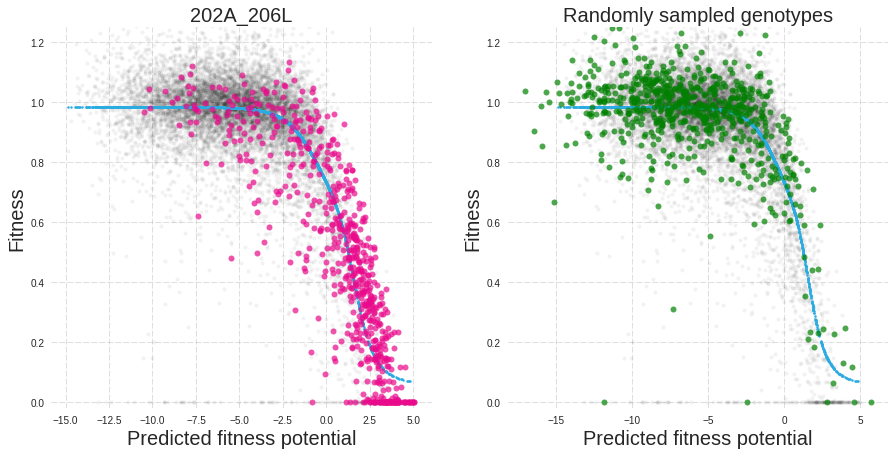

In [295]:
plt.figure(figsize = [15,7])
plt.subplot(1,2,1)
plt.plot(fitness_potential[:10000], true[:10000], 'ok', alpha = 0.05, ms=4);
plt.plot(fitness_potential[:5000], predicted[:5000], '.', color='#2AACE2', alpha = 1, ms=5)
plt.plot(epistaticGenotypesPotential, epistaticGenotypesFitness,'o', color='#EA0A8C', alpha=0.7, ms=6)
plt.xlabel('Predicted fitness potential',fontsize=20)
plt.grid(True, ls='--', lw=0.5, alpha=0.5, dash_capstyle = 'round', c='gray')
plt.ylabel('Fitness',fontsize=20)
plt.ylim(-0.02,1.25)
plt.title(mut_pair,fontsize=20)

plt.subplot(1,2,2)
plt.plot(fitness_potential[:10000], true[:10000], 'ok', alpha = 0.05, ms=4);
plt.plot(fitness_potential[:5000], predicted[:5000], '.', color='#2AACE2', alpha = 1, ms=5)
plt.plot(randomGenotypesPotential, randomGenotypesFitness,'o', color='green', alpha=0.7, ms=6)
plt.xlabel('Predicted fitness potential',fontsize=20)
plt.grid(True, ls='--', lw=0.5, alpha=0.5, dash_capstyle = 'round', c='gray')
plt.ylabel('Fitness',fontsize=20)
plt.ylim(-0.02,1.25)
plt.title('Randomly sampled genotypes',fontsize=20);